# 1. IMPORT LIBRARIES

In [928]:
import os
import sklearn
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import catboost as cb
import xgboost as xgb
import optuna
from datetime import datetime
import warnings

import statsmodels.api as sm

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.decomposition import PCA
#from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (plot_confusion_matrix, auc, plot_roc_curve, roc_curve, f1_score, confusion_matrix, 
                             precision_score, precision_recall_curve, accuracy_score, recall_score, 
                             plot_precision_recall_curve, roc_auc_score, average_precision_score, classification_report)


warnings.filterwarnings("ignore")

%matplotlib inline

In [929]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [930]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [931]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# все результаты, которые вы записываете в текущий каталог, сохраняются как выходные.

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


# 2. FUNCTIONS AND CLASSES

In [932]:
class Numeric_column_аnalyze():
    '''Визуализация и выбросы'''
    def __init__(self, df, columns):
        self.df = df[columns]
        self.columns = columns
    
    def show(self):
        
        for col in self.columns:
            column_log = col + '_log'
            df_log = self.df[col].apply(lambda x: np.log(x + 1))
            df = self.df[col]

            self.show_plots(df, col)
            self.show_plots(df_log, column_log)

    def show_plots(self, data, column, size = 5,):
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))

        fig.suptitle('Hist, QQ-plot and boxplot for {0} '.format(column), fontsize=16)
        ax1.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'green')
        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax2) 

        ax3.boxplot(data.dropna(), vert = False)  # выбросы

        plt.show
        
    def emission_limits(self, col, log = False): # границы выбросов
        if log:
            data = self.df[col].apply(lambda x: np.log(x + 1))
            column = col + '_log'
        else:
            data = self.df[col]
            column = col

        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def amount_emissions(self, col, log = False): 
        if log:
            data = self.df[col].apply(lambda x: np.log(x + 1))
            column = col + '_log'
        else:
            data = self.df[col]
            column = col

        minb, maxb = self.emission_limits(col, log)
        return len(data[data < minb])+ len(data[data > maxb])
    
    def outliers(self, col):
        outlier = self.amount_emissions(col, log = False)
        outlier_log = self.amount_emissions(col, log = True)
        
        print('Sum of outliers for {}: '.format(col), outlier)
        print('Sum of outliers for log({}): '.format(col), outlier_log)
        
class Preprocessing:
    def __init__(self, data):
        self.data = data

    def label_encoder(self, column):
        le = LabelEncoder()
        self.data[column] = le.fit_transform(self.data[column])

    def hot_enc(self, column):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.data[[column]]))
        aux_df.columns = ohe.get_feature_names([f'hot_{column}'])
        self.data = self.data.drop(col, axis=1)
        self.data = pd.concat([self.data, aux_df], axis=1)
        return self.data 

In [933]:
def find_IQR(data, column):
    perc_25 = data[column].quantile(0.25, interpolation="midpoint")
    perc_75 = data[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print('Q1: {}'.format(perc_25), 'Q3: {}'.format(perc_75), 'IQR: {}'.format(IQR),
          'Граница выбросов: [{a},{b}]'.format(a=perc_25 - 1.5*IQR, b=perc_75 + 1.5*IQR), sep='\n')

def month(x):
    month = x.month
    return month
    
def get_scores(report_df, model, X_test, y_test, name):
    '''Create and add metrics into a pandas DF after experiment'''

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    report['PR-AUC'] = precision_score(y_test,model.predict(X_test))
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_Neg'] = precision_score(
        y_test, model.predict(X_test), pos_label=0)
    report['precision_Pos'] = precision_score(
        y_test, model.predict(X_test), pos_label=1)
    report['recall_Neg'] = recall_score(
        y_test, model.predict(X_test), pos_label=0)
    report['recall_Pos'] = recall_score(
        y_test, model.predict(X_test), pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

def age_to_cat(age):
    '''Converts ages to categories'''
    
    if age <= 28:
        cat_age = 'young'
        return cat_age             
    if 28 < age <= 35:
        cat_age = 'not-young'
        return cat_age
    if 35 < age <= 50:
        cat_age = 'midle'
        return cat_age
    if age > 50:
        cat_age = 'oldfag'
        return cat_age
    
def has_no_garant(edu, grnt):
    if edu == 'PGR' or edu == 'ACD':
        grnt = 1
        return grnt
    else:
        grnt = 0
        return grnt

# 3. DESCRIPTION

- client_id - идентификатор клиента  
- education - уровень образования  
- sex - пол заемщика  
- age - возраст заемщика  
- car - флаг наличия автомобиля  
- car_type - флаг автомобиля иномарки  
- decline_app_cnt - количество отказанных прошлых заявок  
- good_work - флаг наличия “хорошей” работы  
- bki_request_cnt - количество запросов в БКИ  
- home_address - категоризатор домашнего адреса  
- work_address - категоризатор рабочего адреса  
- income - доход заемщика  
- foreign_passport - наличие загранпаспорта  
- sna - связь заемщика с клиентами банка  
- first_time - давность наличия информации о заемщике  
- score_bki - скоринговый балл по данным из БКИ  
- region_rating - рейтинг региона  
- app_date - дата подачи заявки  
- default - флаг дефолта по кредиту  

# 4. DATA

In [934]:
# подгрузка данных
df_train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
df_test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_sub = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')
data_directory = '/kaggle/input/sf-dst-scoring/'

In [935]:
print('Train dataset')
display(df_train.info())

print('Test dataset')
display(df_test.info())

Train dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 no

None

Test dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non

None

In [936]:
# в тесте нет колонки default, проверим значение в трейне и после добавим колонку в тест

df_train['default'].value_counts() 

0    64427
1     9372
Name: default, dtype: int64

In [937]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['train'] = 1 # помечаем где у нас трейн
df_test['train'] = 0 # помечаем где у нас тест
df_test['default'] = -1 # добавим в тест недостающую колонку и заполним не встречающимся значением

data = pd.concat([df_train, df_test], ignore_index=True).reset_index(drop=True)

In [938]:
display(data.sample(5))
data.info()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
28062,5236,11JAN2014,SCH,F,62,N,N,0,1,-1.308511,4,50,1,1,35000,1,3,N,0,1
103210,26667,03FEB2014,SCH,M,42,N,N,0,0,-1.592713,1,60,1,2,27500,4,3,Y,-1,0
2509,557,03JAN2014,UGR,M,36,Y,Y,0,0,-1.032137,2,60,2,3,90000,4,1,N,1,1
21905,29297,05FEB2014,SCH,M,57,N,N,0,1,-1.629948,4,80,2,3,25000,1,3,N,0,1
21579,52364,01MAR2014,SCH,M,38,N,N,0,0,-0.991403,0,50,1,1,25000,3,2,N,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [939]:
# количество уникальных значений, первые 10 уникальных значений, количество нулевых значений, тип

data.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(data.isnull().sum(), name='null'))\
    .append(pd.Series(data.dtypes, name='dtype'))\
    .transpose()

,<lambda>,nunique,null,dtype
client_id,"[25905, 63161, 25887, 16222, 101655, 41415, 28...",110148,0,int64
app_date,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",120,0,object
education,"[SCH, GRD, UGR, PGR, ACD, nan]",5,478,object
sex,"[M, F]",2,0,object
age,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29]",52,0,int64
car,"[Y, N]",2,0,object
car_type,"[Y, N]",2,0,object
decline_app_cnt,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9]",24,0,int64
good_work,"[0, 1]",2,0,int64
score_bki,"[-2.00875292, -1.53227621, -1.40814226, -2.057...",102618,0,float64


# 5. EDA

## 5.1. Cleaning and preparation

При ознакомлении с набором данных выяснили что данных нехватает только в колонке education, исправим. Так же уберем client_id, для модели он будет бесполезен.

In [940]:
# заполним пропуски в education 

data.education.fillna('empty', inplace=True)

In [941]:
# поскольку education содержит всего 5 уникальных значений, закодируем их и вручную и через Encoder
education_dict = {'ACD': 4, 'PGR': 3, 'UGR': 2, 'GRD': 13, 'SCH': 0, 'empty': 0}
train['education_map'] = data['education'].map(education_dict)
data['education'] = LabelEncoder().fit_transform(data['education'])

In [942]:
data.drop('client_id',  axis = 1, inplace = True)

In [943]:
# разобъем поля по признакам

target_col = 'default'
time_col = 'app_date'
cat_cols = ['education',  'home_address', 'work_address', 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
num_cols = ['age','decline_app_cnt','region_rating','score_bki','bki_request_cnt','income','delta_time']

In [944]:
# преобразуем дату
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

# расчитаем дельту дней
data['delta_time'] = (datetime.now() - data['app_date']).dt.days

# выберем месяцы
data['month'] = data['app_date'].apply(lambda x: (month(x)))

# уберем app_date оставив дельту и месяцы
data.drop('app_date',  axis = 1, inplace = True)

In [945]:
# закодируем столбцы с двоичными данными

for column in bin_cols:
    data[column] = LabelEncoder().fit_transform(data[column])

## 5.2. Feature Engineering

In [946]:
# определим числовые колонки

numeric_columns = []
for col in data.columns:
    if data[col].dtype != 'object' and len(data[col].unique())<=10:
        print('Unique values in colum {0} : {1}'.format(col,data[col].unique()))
    else:
        print('Numeric column: {}'.format(col))
        numeric_columns.append(col)

Unique values in colum education : [3 1 4 2 0 5]
Unique values in colum sex : [1 0]
Numeric column: age
Unique values in colum car : [1 0]
Unique values in colum car_type : [1 0]
Numeric column: decline_app_cnt
Unique values in colum good_work : [0 1]
Numeric column: score_bki
Numeric column: bki_request_cnt
Unique values in colum region_rating : [50 80 60 40 70 20 30]
Unique values in colum home_address : [1 2 3]
Unique values in colum work_address : [2 3 1]
Numeric column: income
Unique values in colum sna : [4 1 2 3]
Unique values in colum first_time : [1 4 3 2]
Unique values in colum foreign_passport : [0 1]
Unique values in colum default : [ 0  1 -1]
Unique values in colum train : [1 0]
Numeric column: delta_time
Unique values in colum month : [2 3 1 4]


### 5.2.1 Numeric columns

Рассмотрим распределение числовых полей (колонок), с применением логарифма и без

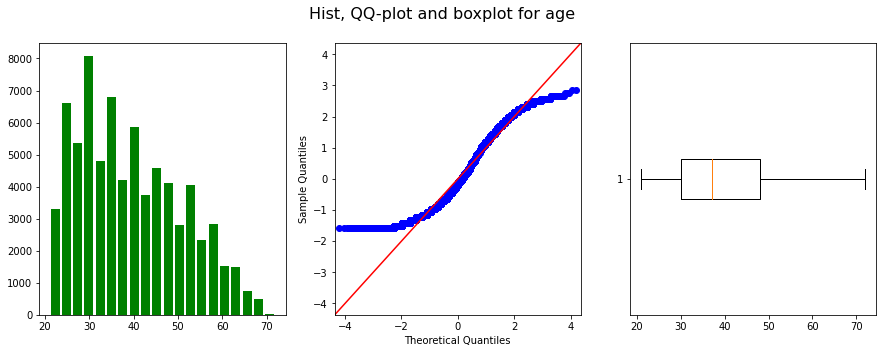

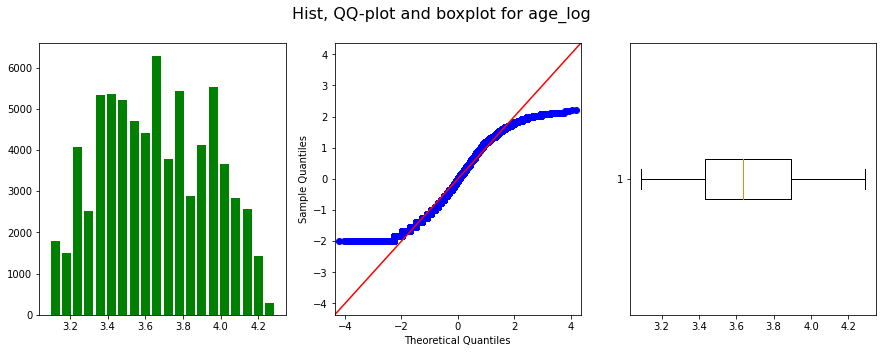

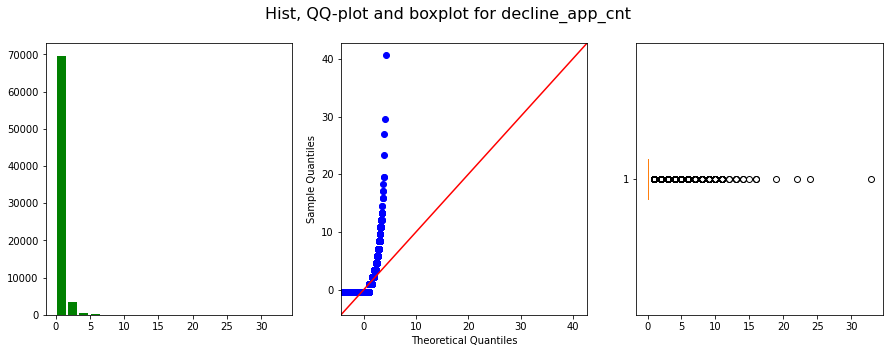

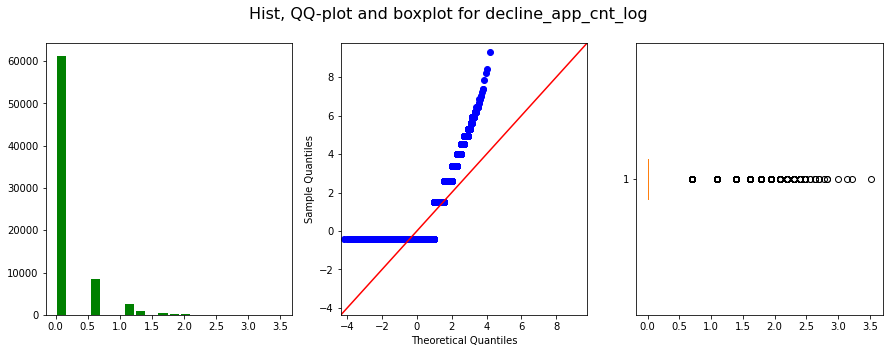

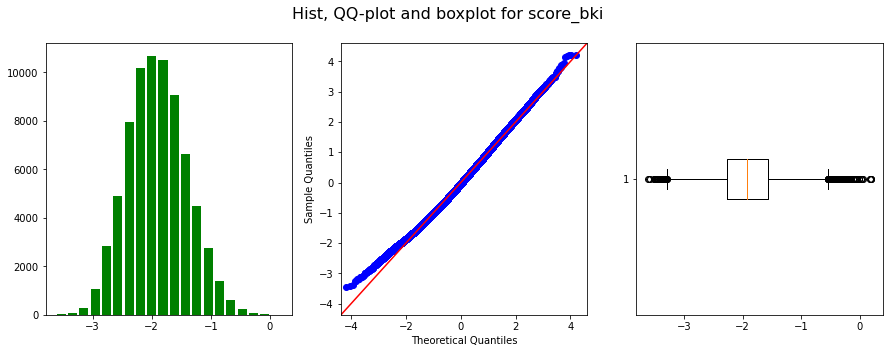

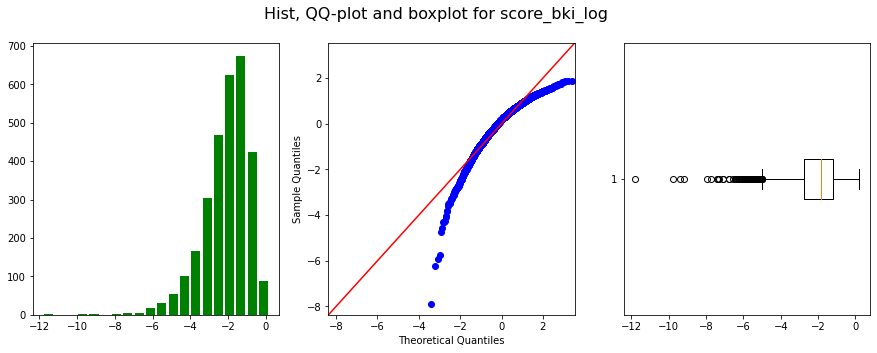

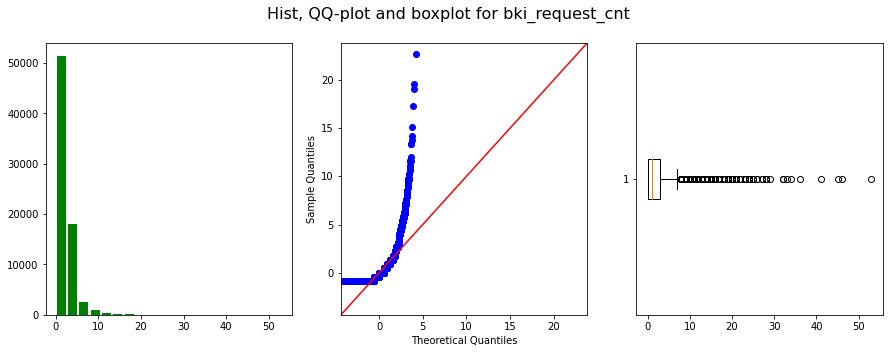

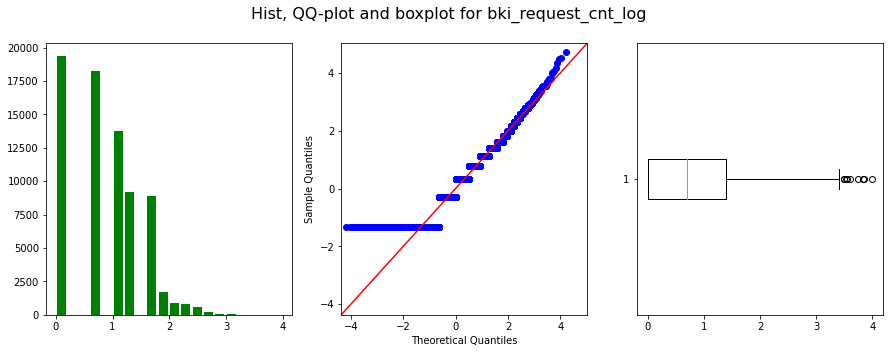

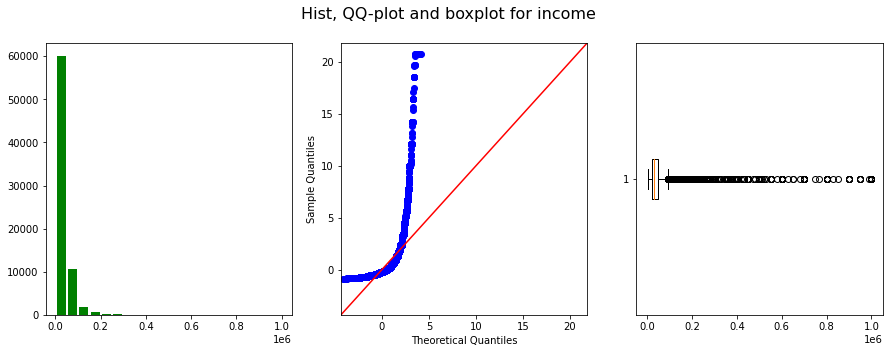

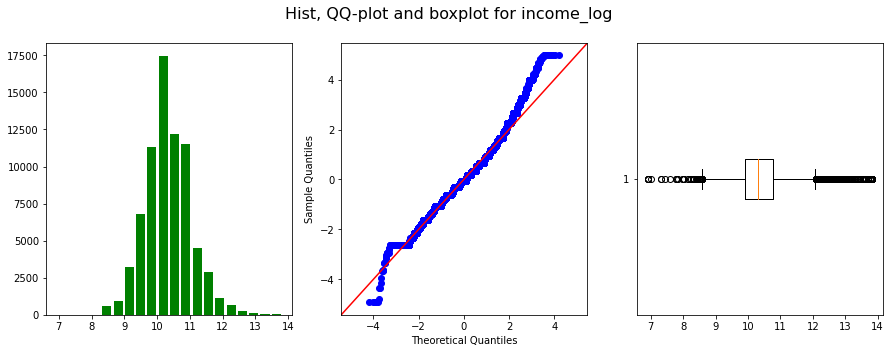

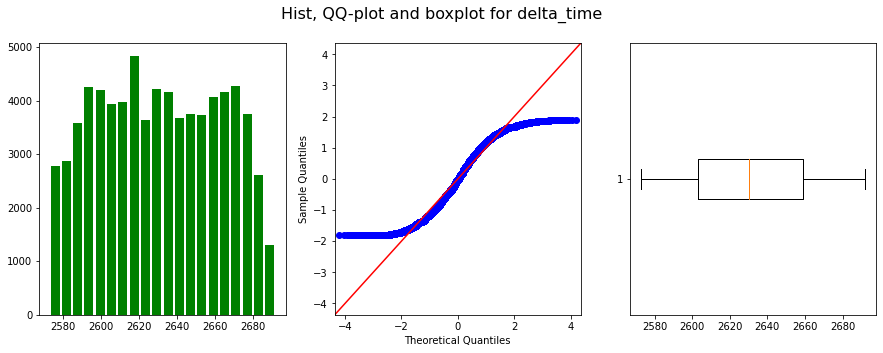

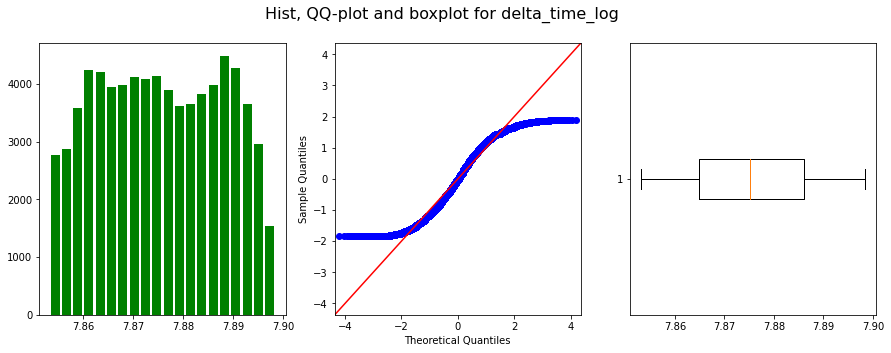

In [947]:
numeric_columns_plots = Numeric_column_аnalyze(data[data.train == 1], numeric_columns)
numeric_columns_plots.show()

#### age - выбросов нет, после применения логарифма распределение становится более нормальным

In [948]:
data.age = (data.age + 1).transform(np.log)

#### decline_app_cnt - распределение сильно смещено влево, с логарифмом дела немного лучше

In [949]:
data.decline_app_cnt = (data.decline_app_cnt + 1).transform(np.log)

#### score_bki - распределение нормальное, поглядим на выбросы

In [950]:
print('Границы без логарифма')
find_IQR(data[data.train == 1], 'score_bki')
print('\nГраницы c логарифмом')
find_IQR(data[data.train == 1].apply(lambda x: np.log(x + 1)), 'score_bki')

Границы без логарифма
Q1: -2.259533835
Q3: -1.56983126
IQR: 0.6897025750000001
Граница выбросов: [-3.2940876975,-0.5352773974999998]

Границы c логарифмом
Q1: -2.734740389586424
Q3: -1.2258538883079335
IQR: 1.5088865012784904
Граница выбросов: [-4.99807014150416,1.0374758636098023]


In [951]:
numeric_columns_plots.outliers('score_bki')

Sum of outliers for score_bki:  351
Sum of outliers for log(score_bki):  85


пока не будем трогать

#### bki_request_cnt - логарифм так же улучшает распределение, применим.

In [952]:
data.bki_request_cnt = (data.bki_request_cnt + 1).transform(np.log)

#### Income - аналогично, с логарифмом лучше.

In [953]:
data.income = data.income.transform(np.log)

#### delta_time - с распределнием всё норм, оставим.

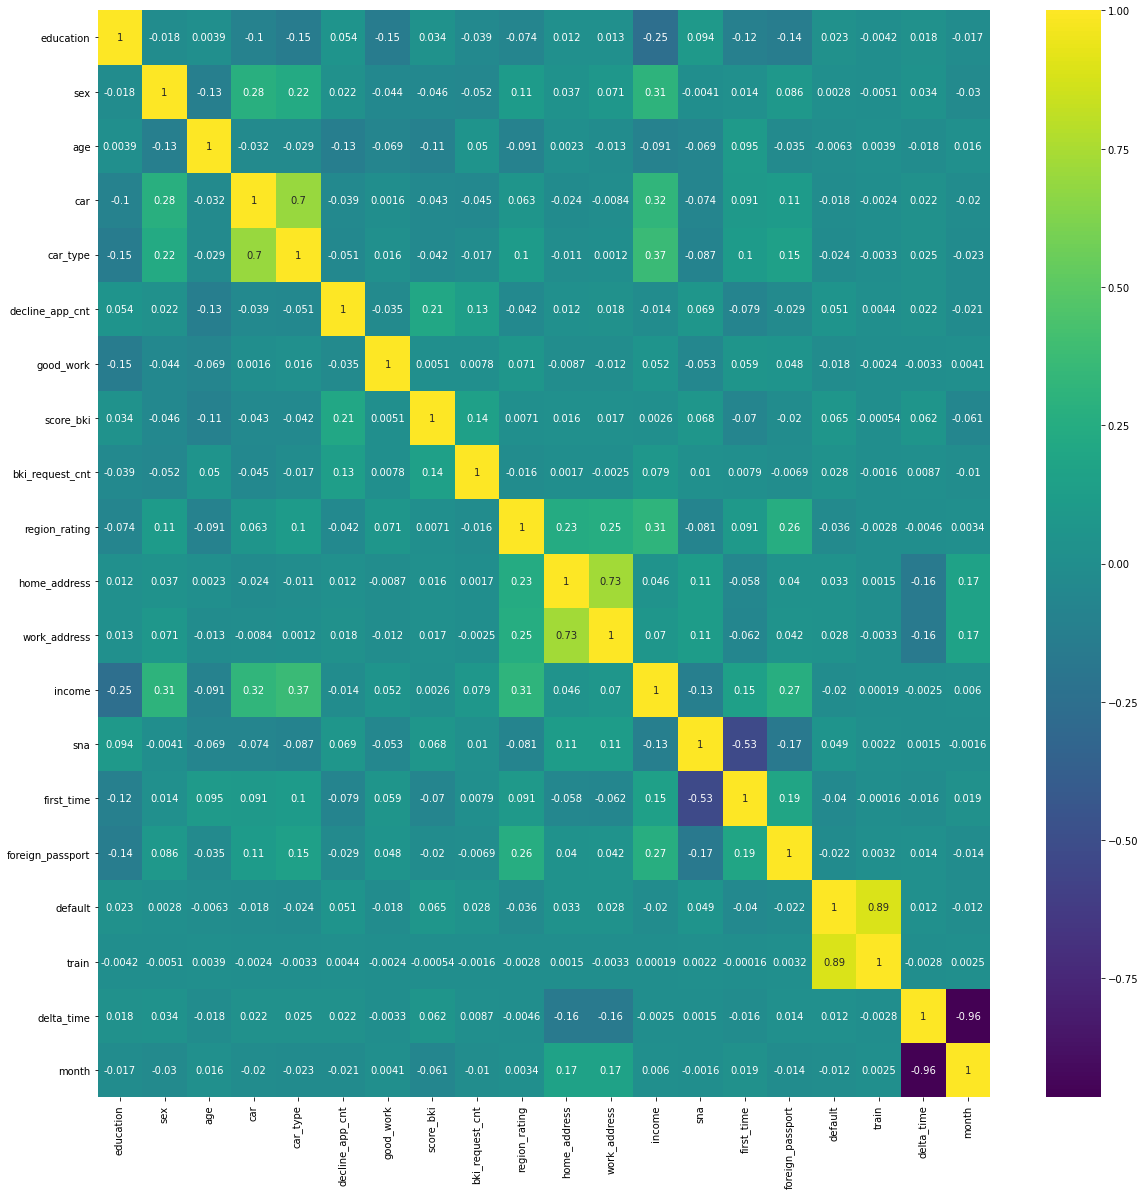

In [954]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'viridis')

#### Сгенерируем новых признаков

In [955]:
data['bki_age_inc'] = (data['score_bki']/data['age'])*data['income']
num_cols.append('bki_age_inc')

In [956]:
data['inc_reg_bki'] = (data['income']/data['region_rating'])*data['score_bki']
num_cols.append('inc_reg_bki')

In [957]:
# средний доход по региону
mean_income_rat = data.groupby('region_rating')['income'].mean().to_dict()
data['mean_income_region'] = data['region_rating'].map(mean_income_rat)
num_cols.append('mean_income_region')

In [958]:
data['bki'] = data['bki_request_cnt']/data['score_bki']
num_cols.append('bki')

In [959]:
# средняя зп по возрасту
mean_income = data.groupby('age')['income'].mean().to_dict()
data['mean_income_age'] = data['age'].map(mean_income)
num_cols.append('mean_income_age')

In [960]:
# маскимальная зп по возрасту
max_income = data.groupby('age')['income'].max().to_dict()
data['max_income_age'] = data['age'].map(max_income)
num_cols.append('max_income_age')

In [961]:
# нормализованная зп
data["normalized_income"] = abs((data.income - data.mean_income_age)/ data.max_income_age)
num_cols.append('normalized_income')

In [962]:
# среднее количество запросов BKI по доходу
mean_bki_inc = data.groupby('income')['bki_request_cnt'].mean().to_dict()
data['mean_requests_income'] = data['income'].map(mean_bki_inc)
num_cols.append('mean_requests_income')

In [963]:
# оценка BKI по возрасту в регионах
data['bki_age_reg'] = (data['score_bki']/data['age'])*data['region_rating']
num_cols.append('bki_age_reg')

In [964]:
# связь заёмщика с клиентом банка и давность отзыва
data['mult_sna_ftime'] = data['sna'] * data['first_time']
num_cols.append('mult_sna_ftime')

In [965]:
# производное образования и зп
data['edu_and_income'] = (data['education'] + 1) * data['income']
num_cols.append('edu_and_income')

In [966]:
# наличие загранпаспорта, хорошей работы и автомобиля
data['success_client'] = (data['foreign_passport'] + 1) * (data['good_work'] + 1) * (data['car'] + 1)
cat_cols.append('success_client')

In [967]:
# наличие загранпаспорта, хорошей работы и автомобиля (без поправки)
data['very_success_client'] = data['foreign_passport'] * data['good_work'] * data['car']
bin_cols.append('very_success_client')

In [968]:
# наличие загранпаспорта и хорошей работы
data['fpassp_and_gwork'] = data['foreign_passport'] * data['good_work'] 
bin_cols.append('fpassp_and_gwork')

In [969]:
# наличие загранпаспорта и автомобиля
data['fpassp_and_car'] = data['foreign_passport'] * data['car']
bin_cols.append('fpassp_and_car')

In [970]:
# наличие хорошей работы и автомобиля
data['gwork_and_car'] = data['good_work'] * data['car']
bin_cols.append('gwork_and_car')

In [971]:
#проверим созданные числовые колонки
num_cols

['age',
 'decline_app_cnt',
 'region_rating',
 'score_bki',
 'bki_request_cnt',
 'income',
 'delta_time',
 'bki_age_inc',
 'inc_reg_bki',
 'mean_income_region',
 'bki',
 'mean_income_age',
 'max_income_age',
 'normalized_income',
 'mean_requests_income',
 'bki_age_reg',
 'mult_sna_ftime',
 'edu_and_income']

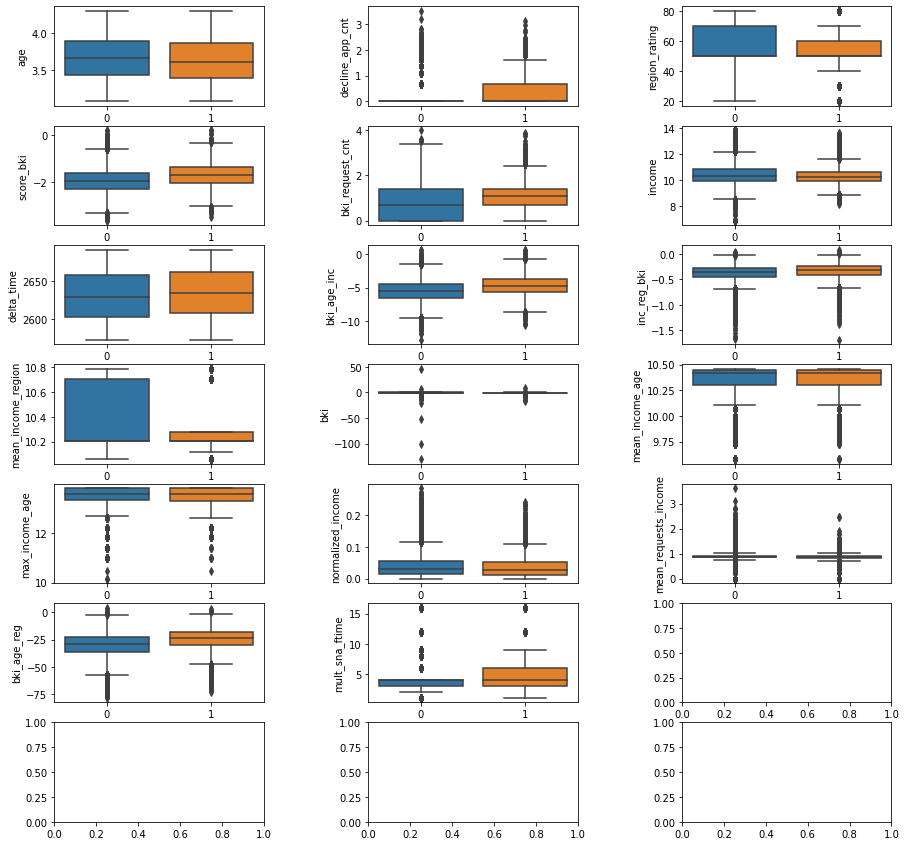

In [972]:
fig, axes = plt.subplots(7, 3, figsize=(15,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()
#data[num_cols]
for i in range(len(num_cols)-1):
    sns.boxplot(x="default", y=num_cols[i], data=data[data.train == 1], orient = 'v', ax=axes[i])

In [973]:
# сменим тип оставшимся колонкам
data[num_cols].info()
data['region_rating'] = data['region_rating'].astype(np.float64)
data['delta_time'] = data['delta_time'].astype(np.float64)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   age                   110148 non-null  float64
 1   decline_app_cnt       110148 non-null  float64
 2   region_rating         110148 non-null  int64  
 3   score_bki             110148 non-null  float64
 4   bki_request_cnt       110148 non-null  float64
 5   income                110148 non-null  float64
 6   delta_time            110148 non-null  int64  
 7   bki_age_inc           110148 non-null  float64
 8   inc_reg_bki           110148 non-null  float64
 9   mean_income_region    110148 non-null  float64
 10  bki                   110148 non-null  float64
 11  mean_income_age       110148 non-null  float64
 12  max_income_age        110148 non-null  float64
 13  normalized_income     110148 non-null  float64
 14  mean_requests_income  110148 non-null  float64
 15  

<AxesSubplot:>

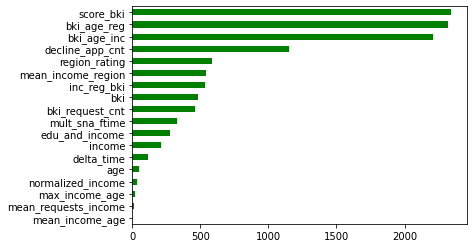

In [974]:
# посмотрим на значимость признаков
data_temp = data.loc[data['train'] == 1] 
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color='green')

In [975]:
# разобьём на категории
data['age_cat'] = 0
data['age_cat'] = data['age'].apply(lambda x:age_to_cat(x))

In [976]:
# Уровень образования даёт небольшую гарантию на трудоустройство и платежеспособность
data['has_no_guarantor'] = 0
data['has_no_guarantor'] = data[['education', 'has_no_guarantor']].apply(
    lambda x: has_no_garant(*x), axis=1)


In [977]:
# разобьем количество отказов и запросов БКИ по категориям
data['decline_cat'] = data['decline_app_cnt'].apply(lambda x: 4 if x >= 4 else x) 
data['bki_request_cat'] = data['bki_request_cnt'].apply(lambda x: 7 if x >= 7 else x) # option 1

In [978]:
# удалим преобразованные колонки
data = data.drop('decline_app_cnt',axis=1)
data = data.drop('bki_request_cnt',axis=1)
data = data.drop('age',axis=1)

In [979]:
# Закодируем двоичные колонки
encoder = Preprocessing(data)
for i in list(['car', 'car_type']):
    encoder.label_encoder(i)
    
# уменьшим размерность, 0 - нет авто, 1 - дешевый, 2 - дорогой
data['car_comb'] = data['car'] + data['car_type']
data = data.drop(['car', 'car_type'], axis=1)

data['car_comb'] = data['car_comb'].astype('category')

In [980]:
# Закодируем то что осталось
for i in list(['sex', 'foreign_passport', 'good_work', 'has_no_guarantor']):
    encoder.label_encoder(i)
    
cols_to_hot = ['education',
               'sna','first_time','car_comb', 'age_cat'] 

for col in cols_to_hot:
    data = encoder.hot_enc(col)

### Feature Scaling

In [981]:
# извлечем адреса
df = data[['work_address', 'home_address']].values

# создадим экземпляр скалера
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Сожмем выбрав только важное, и поместим в новую колонку получив связь домашнего-рабочего адреса
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
data['pca_address'] = pca_data

# удалим обработанные колонки
data = data.drop(['home_address','work_address'],axis=1)

##### Поскольку мы помним, что у нас есть несбалансированные классы, мы должны использовать class_weight в моделях

## 7. Models

In [982]:
# разделим данные
train = data[data.train == 1]
test = data[data.train == 0]
train = train.drop(['train'], axis=1)
test = test.drop(['train', 'default'], axis=1)

X = train.drop('default', axis=1).values
y = train['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED,shuffle=True)

### 7.1 LogisticRegression (naive)

In [983]:
# Создадим модель
lr = LogisticRegression(random_state=RANDOM_SEED)
lr.fit(X_train, y_train)

# получим прогноз
y_pred = lr.predict(X_test)

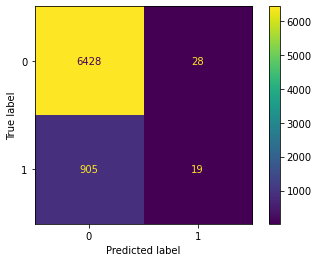

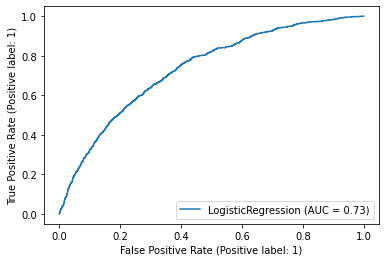

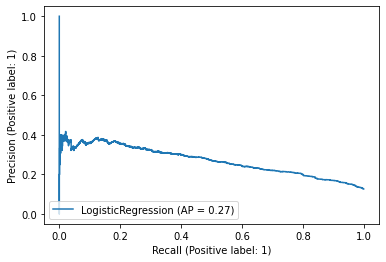

In [984]:
plot_confusion_matrix(lr, X_test, y_test)
plot_roc_curve(lr, X_test, y_test)
plot_precision_recall_curve(lr, X_test, y_test)

Сохраним результаты

In [985]:
# сохраняем результаты для сравнения моделей
df_report = pd.DataFrame(data=None)
df_report = get_scores(df_report, lr, X_test,
                       y_test, 'LogisticRegression_Naive')
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.734151,0.404255,0.039135,0.876585,0.404255,0.995663,0.020563


In [986]:
# делаем submit результатов модели
id_test = df_test['client_id']
submission = pd.DataFrame({'client_id': id_test, 'default': lr.predict_proba(test)[:, 1]})
submission.to_csv('submission_logreg_naive.csv', index=False)

### 7.2 LogisticRegression (balanced)

In [987]:
# Создадим модель
lr = LogisticRegression(max_iter = 10000, random_state=RANDOM_SEED, class_weight='balanced')
lr.fit(X_train, y_train)

# получим прогноз
y_pred = lr.predict(X_test)

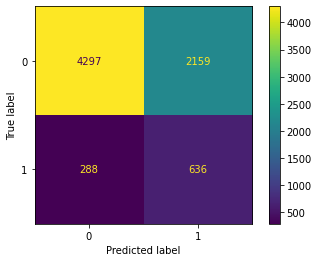

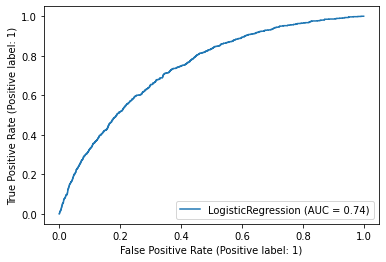

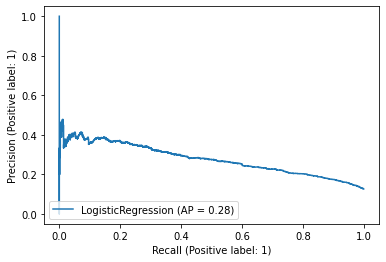

In [988]:
plot_confusion_matrix(lr, X_test, y_test)
plot_roc_curve(lr, X_test, y_test)
plot_precision_recall_curve(lr, X_test, y_test)

In [989]:
# сохраняем результаты для сравнения моделей
df_report = get_scores(df_report, lr, X_test,
                       y_test, 'LogisticRegression_Balanced')
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.734151,0.404255,0.039135,0.876585,0.404255,0.995663,0.020563
LogisticRegression_Balanced,0.740663,0.227549,0.342027,0.937186,0.227549,0.665582,0.688312


In [990]:
# делаем submit результатов модели
id_test = df_test['client_id']
submission = pd.DataFrame({'client_id': id_test, 'default': lr.predict_proba(test)[:, 1]})
submission.to_csv('submission_logreg_balanced.csv', index=False)

### 7.3 LogisticRegression (balanced+hyperparams)

In [991]:
# Подбор лучших гиперпараметров для модели
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 10000.0


In [992]:
# Обучаем модель
main_model = LogisticRegression( 
                           C=2.7825594022071245, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l2', 
                           solver='liblinear', 
                           verbose=0, 
                           max_iter=1000)
main_model.fit(X_train, y_train)

# Предсказываем значения тестовой базы
y_pred_test = main_model.predict(test)
y_pred_prob_test = main_model.predict_proba(test)[:,1]

In [993]:
# сохраняем результаты для сравнения моделей
df_report = get_scores(df_report, lr, X_test,
                       y_test, 'LogisticRegression_Balanced_Hyperparams')
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.734151,0.404255,0.039135,0.876585,0.404255,0.995663,0.020563
LogisticRegression_Balanced,0.740663,0.227549,0.342027,0.937186,0.227549,0.665582,0.688312
LogisticRegression_Balanced_Hyperparams,0.740663,0.227549,0.342027,0.937186,0.227549,0.665582,0.688312


In [994]:
# делаем submit результатов модели
id_test = df_test['client_id']
submission = pd.DataFrame({'client_id': id_test, 'default': lr.predict_proba(test)[:, 1]})
submission.to_csv('submission_logreg_balanced_hyperparams.csv', index=False)

# Submission

In [995]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.734151,0.404255,0.039135,0.876585,0.404255,0.995663,0.020563
LogisticRegression_Balanced,0.740663,0.227549,0.342027,0.937186,0.227549,0.665582,0.688312
LogisticRegression_Balanced_Hyperparams,0.740663,0.227549,0.342027,0.937186,0.227549,0.665582,0.688312


Нативная модель показала неплохие результаты по целевой метрике и PR-AUC
Самое примечательно то что модель лог регрессии только с балансировкой ничем не отличилась по результатам от модели с ветками и гиперпараметрами, что-ж тут я могу только развести руками =) 